In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util import DbHelper
from util.defaults import db2covid as db_options
import util.modelhelper as modelhelper
import math

# Instantiate DbHelper class for executing
# query to database
db = DbHelper(db_options)

In [2]:
min_date = str(db.execute("SELECT MIN(date) FROM COVID19_OPEN_DATA").values.tolist()[0][0])
max_date = str(db.execute("SELECT MAX(date) FROM COVID19_OPEN_DATA").values.tolist()[0][0])

In [3]:
# Options
sr1_code = 'SA'
ndays = 7
lcc_colname = 'LEAD_%dDAYS' % (ndays)

In [4]:
date_index = pd.date_range(start=min_date, end=max_date)

In [5]:
sql = "SELECT DATE, CUMULATIVE_CONFIRMED FROM COVID19_CUMULATIVE_DATA WHERE SUBREGION1_CODE='%s'" % (sr1_code)

cum_confirmed = db.execute(sql)
cum_confirmed.index = date_index

In [6]:
lead_cum_confirmed = db.lead_cum_confirmed_date_range(min_date, max_date, sr1_code, ndays)
lead_cum_confirmed.index = date_index
lead_cum_confirmed.columns = [lcc_colname]

<AxesSubplot:>

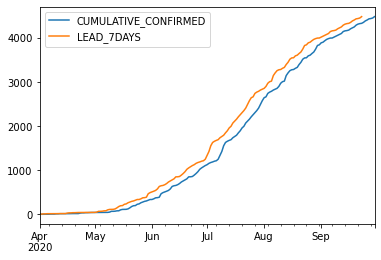

In [7]:
confirmed = pd.concat([cum_confirmed, lead_cum_confirmed], axis=1)

confirmed.plot()

In [8]:
sql = "SELECT "+ \
      "MOBILITY_RETAIL_AND_RECREATION " + \
      "FROM COVID19_DAILY_MOBILITY_CHANGES "+ \
      "WHERE SUBREGION1_CODE='%s'" % (sr1_code)

In [9]:
mobility = db.execute(sql)
mobility.index = date_index

<AxesSubplot:xlabel='MOBILITY_RETAIL_AND_RECREATION', ylabel='LEAD_7DAYS'>

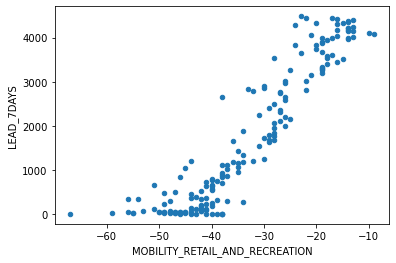

In [10]:
confirmed_vs_mobility = pd.concat([confirmed, mobility], axis=1)

confirmed_vs_mobility.plot.scatter(x='MOBILITY_RETAIL_AND_RECREATION', y=lcc_colname)

In [11]:
covid_X = confirmed_vs_mobility.MOBILITY_RETAIL_AND_RECREATION
covid_y = confirmed_vs_mobility[lcc_colname]

covid_X = np.array(covid_X.values.tolist()).reshape(-1,1)
covid_y = np.array(covid_y.values.tolist())

n_null = ndays * -1

covid_X_unknown = covid_X[n_null:] # Save null y from X dataset

# Bersihkan dari nilai null
covid_X = covid_X[:n_null]
covid_y = covid_y[:n_null]

In [33]:
repo = modelhelper.get_model_above_threshold(covid_X, covid_y, 0.92, 0.4, False)

In [34]:
repo.r2_score()

0.926432065131222

In [35]:
# Baris ini di-uncomment untuk export model ke folder ./model
repo.dump('model/regr-model_%s-%d_%d.joblib' % (sr1_code, ndays, math.ceil(repo.r2_score() * 100)) )

['model/regr-model_SA-7_93.joblib']